# NYC TLC EDA (Course 3)

This notebook performs exploratory data analysis (EDA) on the NYC Taxi and Limousine Commission (TLC) dataset. It includes cleaning steps, feature creation, and visualizations requested by the management team.


In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


In [2]:
from pathlib import Path
base = Path.cwd()
if not (base / 'data' / 'raw').exists():
    base = base.parent
path = list((base / 'data' / 'raw').glob('*.csv'))[0]


In [5]:
df = pd.read_csv(path)

In [6]:
# Basic structure

df.shape


(22699, 18)

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

In [8]:
# Missing values
df.isna().sum().sort_values(ascending=False)


Unnamed: 0               0
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

## Feature engineering
Create time-based fields and trip duration in minutes.


In [9]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
df['pickup_month'] = df['tpep_pickup_datetime'].dt.to_period('M').dt.to_timestamp()
df['pickup_quarter'] = df['tpep_pickup_datetime'].dt.to_period('Q').dt.to_timestamp()
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['speed_mph'] = df['trip_distance'] / (df['trip_duration_min'] / 60)


## Data quality checks
Identify unusual values that should be reviewed during cleaning.


In [10]:
pd.DataFrame({
    'negative_duration': [df['trip_duration_min'].lt(0).sum()],
    'zero_distance': [df['trip_distance'].eq(0).sum()],
    'negative_fare': [df['fare_amount'].lt(0).sum()],
    'zero_passengers': [df['passenger_count'].eq(0).sum()],
})


,negative_duration,zero_distance,negative_fare,zero_passengers
0,1,148,14,33


## Summary statistics


In [11]:
df[['trip_distance', 'fare_amount', 'trip_duration_min', 'passenger_count']].describe()


,trip_distance,fare_amount,trip_duration_min,passenger_count
count,22699.000000,22699.000000,22699.000000,22699.000000
mean,2.913313,13.026629,17.013777,1.642319
std,3.653171,13.243791,61.996482,1.285231
min,0.000000,-120.000000,-16.983333,0.000000
25%,0.990000,6.500000,6.650000,1.000000
50%,1.610000,9.500000,11.183333,1.000000
75%,3.060000,14.500000,18.383333,2.000000
max,33.960000,999.990000,1439.550000,6.000000


## Visualizations
Create plots requested by the management team.


In [12]:
# Filter to reasonable ranges for clearer plots
df_clean = df[(df['trip_duration_min'] > 0) & (df['trip_duration_min'] <= 120) & (df['trip_distance'] >= 0)]


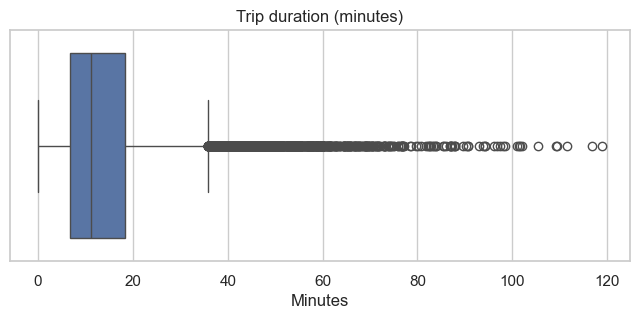

In [13]:
plt.figure(figsize=(8, 3))
sns.boxplot(x=df_clean['trip_duration_min'])
plt.title('Trip duration (minutes)')
plt.xlabel('Minutes')
plt.show()


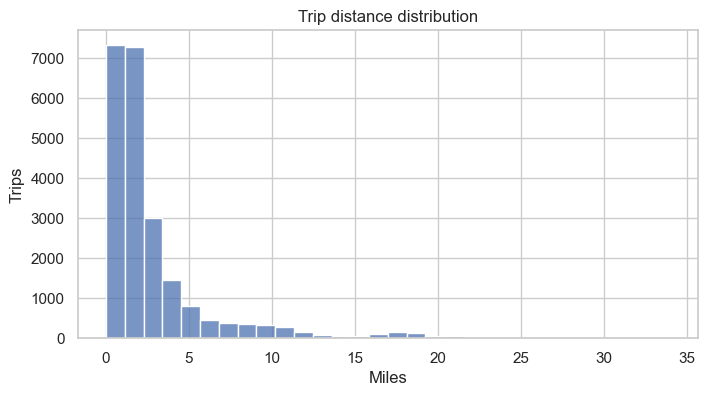

In [14]:
plt.figure(figsize=(8, 4))
sns.histplot(df_clean['trip_distance'], bins=30)
plt.title('Trip distance distribution')
plt.xlabel('Miles')
plt.ylabel('Trips')
plt.show()


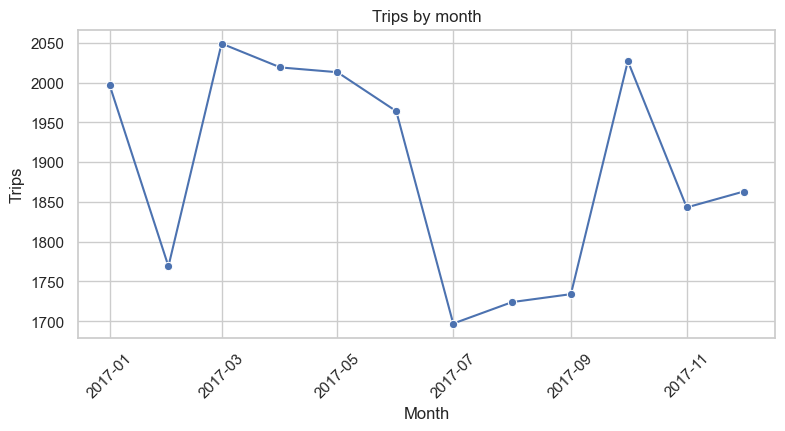

In [15]:
monthly = df.groupby('pickup_month').size().reset_index(name='trips')
plt.figure(figsize=(9, 4))
sns.lineplot(data=monthly, x='pickup_month', y='trips', marker='o')
plt.title('Trips by month')
plt.xlabel('Month')
plt.ylabel('Trips')
plt.xticks(rotation=45)
plt.show()


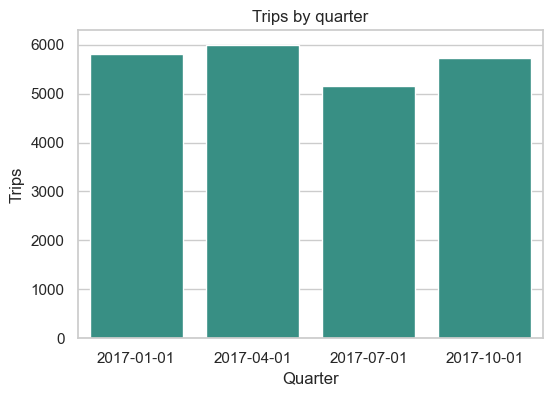

In [16]:
quarterly = df.groupby('pickup_quarter').size().reset_index(name='trips')
plt.figure(figsize=(6, 4))
sns.barplot(data=quarterly, x='pickup_quarter', y='trips', color='#2a9d8f')
plt.title('Trips by quarter')
plt.xlabel('Quarter')
plt.ylabel('Trips')
plt.show()


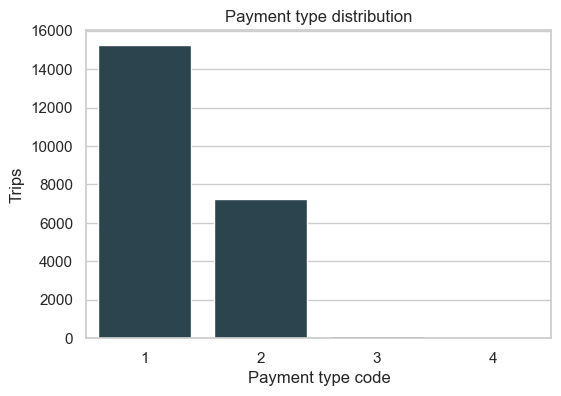

In [17]:
payment_counts = df['payment_type'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
sns.barplot(x=payment_counts.index, y=payment_counts.values, color='#264653')
plt.title('Payment type distribution')
plt.xlabel('Payment type code')
plt.ylabel('Trips')
plt.show()


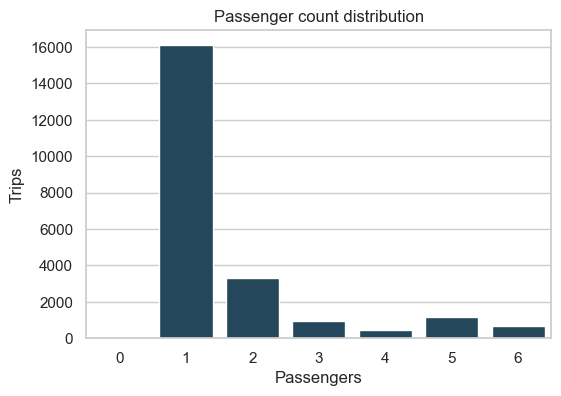

In [18]:
passenger_counts = df['passenger_count'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
sns.barplot(x=passenger_counts.index, y=passenger_counts.values, color='#1b4965')
plt.title('Passenger count distribution')
plt.xlabel('Passengers')
plt.ylabel('Trips')
plt.show()


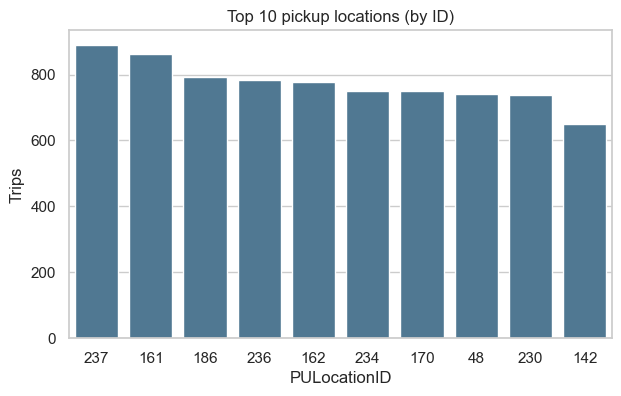

In [19]:
top_pu = df['PULocationID'].value_counts().head(10)
plt.figure(figsize=(7, 4))
sns.barplot(x=top_pu.index.astype(str), y=top_pu.values, color='#457b9d')
plt.title('Top 10 pickup locations (by ID)')
plt.xlabel('PULocationID')
plt.ylabel('Trips')
plt.show()


## Notes for Tableau
Export a cleaned dataset for Tableau and build accessible dashboards. See `tableau_viz_plan.md` for details.


In [ ]:
df_clean.to_csv("C:/Users/Ling Jun/Desktop/Upgrade/learning/automatidata/data/processed", index = False)

OSError: Cannot save file into a non-existent directory: 'data\processed'